script to clean up proteins and generate htmd features for the pockets

In [2]:
from prody import *
import os, sys
import numpy as np

import logging
import tempfile
import urllib.request as request
from functools import lru_cache
import Bio.PDB as PDB
# import htmd.molecule.molecule as htmdmol
# import htmd.molecule.voxeldescriptors as htmdvox
import torch
import subprocess

import pickle
import time
import pandas as pd

from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

import seaborn as sns


logger = logging.getLogger(__name__)

In [2]:
from tqdm import tqdm

In [3]:
def remove_water_and_hets(pdb_path: str, output_file: str) -> str:

    class NonWaterAndHetsSelect(PDB.Select):
        def accept_residue(self, residue):
            if residue.id[0] != ' ':
                return False
            elif residue.resname == 'HOH':
                return False
            return True

    parser = PDB.PDBParser(PERMISSIVE=1, QUIET=True)
    structure = parser.get_structure('protein', pdb_path)
    model = structure[0]

    io = PDB.PDBIO()
    io.set_structure(model)
    io.save(output_file, NonWaterAndHetsSelect())


def htmd_featurizer(pdb_entries, skip_existing=True):
    """ Ensures than all entries have their HTMD featurization precomputed """

    mgl_command = 'conda run -p {}/deeplytough_mgltools pythonsh {}/deeplytough_mgltools/MGLToolsPckgs/AutoDockTools/Utilities24/prepare_receptor4.py -r {} -U nphs_lps_waters -A hydrogens'
    conda_prefix=os.environ.get('CONDA_MAIN')

    for entry in tqdm(pdb_entries):
        pdb_path = os.path.abspath(entry['protein'])
        npz_path = os.path.abspath(entry['protein_htmd'])
        if skip_existing and os.path.exists(npz_path):
            continue
            
        logger.info(f'Pre-processing {pdb_path} with HTMD...')
        if not os.path.exists(pdb_path):
            logger.error(f'{pdb_path} not found, skipping its pre-preprocessing.')
            continue

        output_dir = os.path.dirname(npz_path)
        os.makedirs(output_dir, exist_ok=True)

        def compute_channels():
            pdbqt_path = os.path.join(output_dir, os.path.basename(pdb_path)) + 'qt'
            if not os.path.exists(pdbqt_path) and os.path.exists(pdbqt_path.replace('.pdb', '_model1.pdb')):
                os.rename(pdbqt_path.replace('.pdb', '_model1.pdb'), pdbqt_path)
            mol = htmdmol.Molecule(pdbqt_path)

            # slaughtered getVoxelDescriptors()
            channels = htmdvox._getAtomtypePropertiesPDBQT(mol)
            sigmas = htmdvox._getRadii(mol)
            channels = sigmas[:, np.newaxis] * channels.astype(float)
            coords = mol.coords[:, :, mol.frame]
            
            np.savez(npz_path, channels=channels, coords=coords)
            

        # process pdb -> pdbqt (output written to `output_dir`)
        try:
            subprocess.check_call(mgl_command.format(conda_prefix,conda_prefix,pdb_path).split(), cwd=output_dir, stdout=sys.stderr)
        except Exception as err1:
            try:
                # Put input through obabel to handle some problematic formattings, it's parser seems quite robust
                # (could go directly to pdbqt with `-xr -xc -h` but somehow the partial charges are all zero)
                subprocess.check_call(['obabel', pdb_path, '-O', pdb_path, '-h'], stdout=sys.stderr)
                subprocess.check_call(mgl_command.format(conda_prefix,conda_prefix,pdb_path).split(), cwd=output_dir, stdout=sys.stderr)
            except Exception as err2:
                logger.exception(err2)
                continue

        # compute channels
        try:
            compute_channels()
        except Exception as err3:
            logger.exception(err3)

In [3]:
#load affinity

affinity = pd.read_csv('affinity.csv')

list(affinity['PDB code'])

['1a9u',
 '1aq1',
 '1bkm',
 '1bl6',
 '1bl7',
 '1bmk',
 '1di8',
 '1di9',
 '1dm2',
 '1e9h',
 '1f0q',
 '1fv9',
 '1fvt',
 '1fvv',
 '1g5s',
 '1h00',
 '1h01',
 '1h07',
 '1h08',
 '1h0w',
 '1h1q',
 '1h1r',
 '1iep',
 '1ijr',
 '1jvp',
 '1ke5',
 '1ke6',
 '1ke7',
 '1ke8',
 '1ke9',
 '1m51',
 '1m7q',
 '1nhx',
 '1o41',
 '1o42',
 '1o43',
 '1o44',
 '1o45',
 '1o46',
 '1o47',
 '1o48',
 '1o49',
 '1o4a',
 '1o4b',
 '1o4d',
 '1o4e',
 '1o4f',
 '1o4g',
 '1o4h',
 '1o4i',
 '1o4j',
 '1o4k',
 '1o4l',
 '1o4m',
 '1o4n',
 '1o4o',
 '1o4p',
 '1o4q',
 '1o4r',
 '1oe0',
 '1ogu',
 '1oi9',
 '1oiq',
 '1oir',
 '1oit',
 '1oiu',
 '1oiy',
 '1okv',
 '1okw',
 '1oky',
 '1okz',
 '1ol1',
 '1ol2',
 '1ouk',
 '1ouy',
 '1ove',
 '1p2a',
 '1p5e',
 '1pmn',
 '1pmu',
 '1pmv',
 '1pxi',
 '1pxj',
 '1pxk',
 '1pxl',
 '1q3d',
 '1q3w',
 '1q41',
 '1qpe',
 '1r78',
 '1shd',
 '1skj',
 '1sve',
 '1svg',
 '1svh',
 '1szm',
 '1t46',
 '1u59',
 '1ung',
 '1unh',
 '1unl',
 '1urc',
 '1urw',
 '1uu3',
 '1uu7',
 '1uu8',
 '1uu9',
 '1uv5',
 '1uvr',
 '1uwh',
 '1v1k',
 

In [5]:
#extract htmd features from pockets
import re

pdb_list = list(affinity['PDB code'])
def compute_descriptors(prot_dir, pocket_dir, htmd=True):

    npz_root = f'{prot_dir}/htmd'
    proteins =[]
    pockets = []

    if not os.path.exists(npz_root):
        os.makedirs(npz_root)

    custom_pdbs = set()
    
    for protein_file in os.listdir(prot_dir):
        protein = protein_file.split('_')[0]
        if protein in pdb_list:
            protein_path = os.path.join(prot_dir, protein_file)
            proteins.append(protein_path)
        
    for pocket_file in os.listdir(pocket_dir):
        pocket = pocket_file.split('_')[0]
        if pocket in pdb_list:
            pocket_path = os.path.join(pocket_dir, pocket_file)
            pockets.append(pocket_path)
    
    def create_dicts(file_list):

        return {path.split('/')[-1].split('_')[0]: path for path in file_list}
        
    dict1 = create_dicts(proteins)
    dict2 = create_dicts(pockets)
    custom_pdbs=set()

    for filename, path1 in dict1.items():
        if filename in dict2:
            custom_pdbs.add((path1, dict2[filename]))
            
    entries = []
    for pdb, pocket in custom_pdbs:
        entries.append({'protein': pdb,
                    'pocket': pocket,
                    'protein_htmd': os.path.join(npz_root, pdb.split('/')[-1]).replace('.pdb', '.npz'),
                    'key': pdb + ',' + pocket})
    if htmd==False:
        return entries
            
    htmd_featurizer(entries)

    return entries

proteins = '../kinase_prot/proteins/'
pockets = '../kinase_prot/pockets_clean/'

entries = compute_descriptors(proteins, pockets)

print(entries)


  9%|▉         | 167/1858 [07:10<1:03:14,  2.24s/it]Traceback (most recent call last):
  File "/net/galaxy/home/koes/vratins/miniforge3/envs/deeplytough_mgltools/MGLToolsPckgs/AutoDockTools/Utilities24/prepare_receptor4.py", line 179, in <module>
    dict=dictionary)    
  File "MGLToolsPckgs/AutoDockTools/MoleculePreparation.py", line 560, in __init__
  File "MGLToolsPckgs/AutoDockTools/MoleculePreparation.py", line 126, in __init__
  File "MGLToolsPckgs/AutoDockTools/MoleculePreparation.py", line 176, in repairMol
  File "MGLToolsPckgs/AutoDockTools/MoleculePreparation.py", line 189, in addHydrogens
  File "MGLToolsPckgs/MolKit/hydrogenBuilder.py", line 81, in addHydrogens
  File "MGLToolsPckgs/PyBabel/addh.py", line 92, in addHydrogens
  File "MGLToolsPckgs/PyBabel/addh.py", line 149, in place_hydrogens1
  File "MGLToolsPckgs/PyBabel/addh.py", line 303, in add_methyl_hydrogen
  File "/net/galaxy/home/koes/vratins/miniforge3/envs/deeplytough_mgltools/lib/python2.5/UserList.py", line 

[{'protein': '../kinase_prot/proteins/3qc4_protein.pdb', 'pocket': '../kinase_prot/pockets_clean/3qc4_complex2.pdb', 'protein_htmd': '../kinase_prot/proteins//htmd/3qc4_protein.npz', 'key': '../kinase_prot/proteins/3qc4_protein.pdb,../kinase_prot/pockets_clean/3qc4_complex2.pdb'}, {'protein': '../kinase_prot/proteins/4fob_protein.pdb', 'pocket': '../kinase_prot/pockets_clean/4fob_complex2.pdb', 'protein_htmd': '../kinase_prot/proteins//htmd/4fob_protein.npz', 'key': '../kinase_prot/proteins/4fob_protein.pdb,../kinase_prot/pockets_clean/4fob_complex2.pdb'}, {'protein': '../kinase_prot/proteins/4dea_protein.pdb', 'pocket': '../kinase_prot/pockets_clean/4dea_complex2.pdb', 'protein_htmd': '../kinase_prot/proteins//htmd/4dea_protein.npz', 'key': '../kinase_prot/proteins/4dea_protein.pdb,../kinase_prot/pockets_clean/4dea_complex2.pdb'}, {'protein': '../kinase_prot/proteins/3hvc_protein.pdb', 'pocket': '../kinase_prot/pockets_clean/3hvc_complex2.pdb', 'protein_htmd': '../kinase_prot/proteins

In [6]:
def deeptough(entries): 
    sys.path.append('/net/galaxy/home/koes/vratins/CrossDocked2.0/deeplytough_custom/deeplytough')
    from matchers import DeeplyTough
    from datasets import Custom
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    batch = 32
    nworkers = 8
    net = '/net/galaxy/home/koes/vratins/CrossDocked2.0/deeplytough_custom/networks/deeplytough_toughm1_test.pth.tar'

    matcher = DeeplyTough(net, device=device, batch_size=batch, nworkers=nworkers)
    entries = matcher.precompute_descriptors(entries)

    pocket_names = [os.path.splitext(os.path.basename(entry["pocket"]))[0] for entry in entries if entry["descriptor"] is not None]
    features = [entry["descriptor"].numpy()[0] for entry in entries if entry["descriptor"] is not None]
    
    df = pd.DataFrame(features, index=pocket_names)
    
    return df

start = time.time()

df_kinome = deeptough(entries)

with open('deeptough_kinome.pkl', 'wb') as pkl_file:
    pickle.dump(df_kinome, pkl_file)

end = time.time()
print('Time taken: ',(end-start)/60.0)

/net/galaxy/home/koes/vratins/CrossDocked2.0/deeplytough_custom/deeplytough/matchers/deeply_tough.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/net/pulsar/home/koes/vratins/anaconda3/envs/mmtf/lib/python3.8/site-packages/se3cnn-0.0.0-py3.8.egg/se3cnn/non_linearities/gated_activation.py:42: SyntaxWarning: "is" with a literal. Did you mean "=="?
/net/pulsar/home/koes/vratins/anaconda3/envs/mmtf/lib/python3.8/site-packages/se3cnn-0.0.0-py3.8.egg/se3cnn/non_linearities/gated_activation.py:44: SyntaxWarning: "is" with a literal. Did you mean "=="?
/net/pulsar/home/koes/vratins/anaconda3/envs/mmtf/lib/python3.8/site-packages/se3cnn-0.0.0-py3.8.egg/se3cnn/non_linearities/gated_activation.py:42: SyntaxWarning: "is" with a literal. Did you mean "=="?
/net/pulsar/home/koes/vratins/anaconda3/envs/mmtf/lib/python3.8/site-packages/se3cnn-0.0.0-py3.8.egg/se3

compute 0.pkl.gz... save 0.pkl.gz... done
compute 0.pkl.gz... save 0.pkl.gz... done
compute 1.pkl.gz... save 1.pkl.gz... done
compute 1.pkl.gz... save 1.pkl.gz... done
compute 2.pkl.gz... save 2.pkl.gz... done
compute 2.pkl.gz... save 2.pkl.gz... done
compute 3.pkl.gz... save 3.pkl.gz... done
compute 3.pkl.gz... save 3.pkl.gz... done
compute 4.pkl.gz... save 4.pkl.gz... done
compute 5.pkl.gz... save 5.pkl.gz... done
compute 4.pkl.gz... save 4.pkl.gz... done
compute 6.pkl.gz... save 6.pkl.gz... done
compute 5.pkl.gz... save 5.pkl.gz... done
compute 7.pkl.gz... save 7.pkl.gz... done
compute 6.pkl.gz... save 6.pkl.gz... done
compute 7.pkl.gz... save 7.pkl.gz... done
compute 8.pkl.gz... save 8.pkl.gz... done
compute 9.pkl.gz... save 9.pkl.gz... done
compute 10.pkl.gz... save 10.pkl.gz... done
compute 11.pkl.gz... save 11.pkl.gz... done
compute 12.pkl.gz... save 12.pkl.gz... done
compute 13.pkl.gz... save 13.pkl.gz... done
compute 14.pkl.gz... save 14.pkl.gz... done
compute 8.pkl.gz... save

0it [00:00, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

/net/pulsar/home/koes/vratins/anaconda3/envs/mmtf/lib/python3.8/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/net/pulsar/home/koes/vratins/anaconda3/envs/mmtf/lib/python3.8/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/net/pulsar/home/koes/vratins/anaconda3/envs/mmtf/lib/python3.8/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Time taken:  0.7752649188041687


In [3]:
with open('deeptough_kinome.pkl', 'rb') as pkl_file:
    df_kinome = pickle.load(pkl_file)

df_kinome.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
3qc4_complex2,-0.000121,0.179341,0.000211,0.165871,0.000260,-0.000577,0.000556,-0.166315,-0.000104,0.001926,...,-0.197857,-0.000176,-0.000070,-0.000090,-0.000043,0.000332,0.000245,-0.000065,-0.000422,-0.000475
4fob_complex2,-0.000114,0.159179,0.000207,0.173602,0.000273,-0.000570,0.000511,-0.194982,-0.000099,0.001835,...,-0.192000,-0.000164,-0.000067,-0.000086,-0.000091,0.000105,0.000212,-0.000051,-0.000442,-0.000420
4dea_complex2,-0.000111,0.154081,0.000213,0.175767,0.000281,-0.000571,0.000497,-0.199414,-0.000097,0.001796,...,-0.192833,-0.000154,-0.000058,-0.000083,-0.000110,0.000082,0.000200,-0.000031,-0.000450,-0.000400
3hvc_complex2,-0.000118,0.170417,0.000198,0.170628,0.000263,-0.000570,0.000531,-0.187470,-0.000103,0.001888,...,-0.190755,-0.000179,-0.000079,-0.000090,-0.000068,0.000136,0.000229,-0.000074,-0.000432,-0.000449
3ti1_complex2,-0.000122,0.187234,0.000200,0.165020,0.000249,-0.000568,0.000560,-0.163543,-0.000105,0.001929,...,-0.196284,-0.000184,-0.000079,-0.000092,-0.000029,0.000326,0.000252,-0.000085,-0.000411,-0.000486


In [4]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_kinome)

pca = PCA(n_components=5)  
components = pca.fit_transform(df_scaled)

pca_df = pd.DataFrame(data=components, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

print("Explained Variance Ratio:", pca.explained_variance_ratio_)

agg_clustering = AgglomerativeClustering()
cluster_labels = agg_clustering.fit_predict(df_scaled)

# dbs = DBSCAN(eps=1.9)
# db_cluster = dbs.fit_predict(df_scaled)

Explained Variance Ratio: [0.5863437  0.2707409  0.0816462  0.04938322 0.00606483]


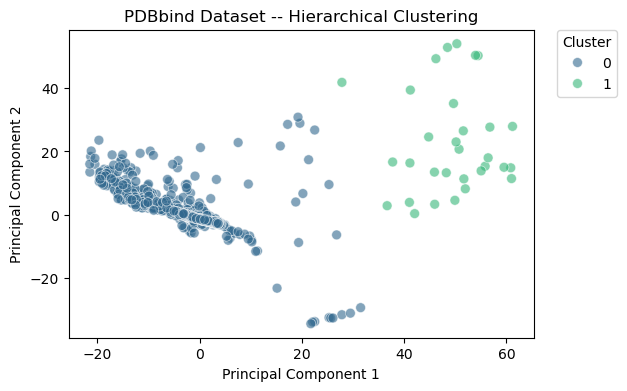

In [5]:
#clustering result from method 1
plt.figure(figsize=(6, 4))
sns.scatterplot(data=pca_df, x=pca_df['PC1'], y=pca_df['PC2'], hue=cluster_labels, palette='viridis', s=50, alpha=0.6)
plt.title('PDBbind Dataset -- Hierarchical Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [9]:
import requests, json, datetime
from tqdm import tqdm


r = requests.get('https://search.rcsb.org/rcsbsearch/v2/query',params={'json': '''{ "query":{
      "type": "terminal",
      "label": "text",
      "service": "text",
      "parameters": {
        "attribute": "rcsb_entry_info.nonpolymer_entity_count",
        "operator": "greater",
        "negation": false,
        "value": 0
      }
    },
  "request_options": {
    "return_all_hits": true
  },
    "return_type": "entry"
  }'''})

PDBs = json.loads(r.text)
PDBs = [r['identifier'] for r in PDBs['result_set']]

query = """
{
  entries(entry_ids:[%s]){
    rcsb_id
    polymer_entities {
    rcsb_cluster_membership {
        cluster_id
        identity
    }
      rcsb_polymer_entity_container_identifiers {
        auth_asym_ids
      }
    }
  }
}"""

info = []

for i in tqdm(range(0, len(PDBs), 100)):
    chunk = PDBs[i:i+100]
    response = requests.post('https://data.rcsb.org/graphql', json={'query': query % ','.join(map(lambda p: f'"{p}"', chunk))})
    r = json.loads(response.text)
    for e in r['data']['entries']:
        pdb = e['rcsb_id']
        if e['polymer_entities']:
            for entity in e['polymer_entities']:
                if entity['rcsb_cluster_membership']:
                    datum = {}
                    for cluster in entity['rcsb_cluster_membership']:
                        datum[f'clust{cluster["identity"]}'] = cluster['cluster_id']

                    name = f'{pdb}_' + ''.join(entity['rcsb_polymer_entity_container_identifiers']['auth_asym_ids'])
                    datum['name'] = name
                    datum['pdb'] = pdb
                    info.append(datum)

info = pd.DataFrame(info)

100%|██████████| 1663/1663 [15:23<00:00,  1.80it/s]


In [10]:
info.head()

,clust100,clust95,clust90,clust70,clust50,clust30,name,pdb
0,15546,109,21,52,106,224,106M_A,106M
1,956248,11,18,47,101,228,108L_A,108L
2,318141,11,18,47,101,228,111L_A,111L
3,1783,109,21,52,106,224,111M_A,111M
4,1783,109,21,52,106,224,112M_A,112M


In [20]:
info.to_csv('sequence_info.csv')

In [23]:
#get cluster IDs

In [30]:
info = pd.read_csv('sequence_info.csv')

ligand_embeddings = pd.read_csv('ligand_embeddings.csv')

affinity = pd.read_csv('affinity.csv')

with open('deeptough_kinome.pkl', 'rb') as pkl_file:
    df_kinome = pickle.load(pkl_file)

In [31]:
info.head()

,Unnamed: 0,clust100,clust95,clust90,clust70,clust50,clust30,name,year,pdb
0,0,901587,775220,723779,47,101,228,103L_A,2014,103L
1,1,5521,109,21,52,107,227,103M_A,2014,103M
2,2,15494,109,21,52,107,227,106M_A,2014,106M
3,3,1774,109,21,52,107,227,112M_A,2014,112M
4,4,817003,11,18,47,101,228,126L_A,2014,126L


In [32]:
df_kinome.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
3qc4_complex2,-0.000121,0.179341,0.000211,0.165871,0.000260,-0.000577,0.000556,-0.166315,-0.000104,0.001926,...,-0.197857,-0.000176,-0.000070,-0.000090,-0.000043,0.000332,0.000245,-0.000065,-0.000422,-0.000475
4fob_complex2,-0.000114,0.159179,0.000207,0.173602,0.000273,-0.000570,0.000511,-0.194982,-0.000099,0.001835,...,-0.192000,-0.000164,-0.000067,-0.000086,-0.000091,0.000105,0.000212,-0.000051,-0.000442,-0.000420
4dea_complex2,-0.000111,0.154081,0.000213,0.175767,0.000281,-0.000571,0.000497,-0.199414,-0.000097,0.001796,...,-0.192833,-0.000154,-0.000058,-0.000083,-0.000110,0.000082,0.000200,-0.000031,-0.000450,-0.000400
3hvc_complex2,-0.000118,0.170417,0.000198,0.170628,0.000263,-0.000570,0.000531,-0.187470,-0.000103,0.001888,...,-0.190755,-0.000179,-0.000079,-0.000090,-0.000068,0.000136,0.000229,-0.000074,-0.000432,-0.000449
3ti1_complex2,-0.000122,0.187234,0.000200,0.165020,0.000249,-0.000568,0.000560,-0.163543,-0.000105,0.001929,...,-0.196284,-0.000184,-0.000079,-0.000092,-0.000029,0.000326,0.000252,-0.000085,-0.000411,-0.000486


In [33]:
affinity.head()

,Unnamed: 0,ID,PDB code,Subset,Complex Type,Resolution,Affinity Data,pKd pKi pIC50,Release Year,Protein Name,...,Exact Mass,No. of atoms,No. of bonds,Polar Surface Area,XLOGP3,open banel LogP,HB donor,HB acceptor,Rotatable bonds,Canonical SMILES
0,7,8,1a9u,general,Protein-Ligand,2.5,IC50=0.048uM,7.32,1999,p38 map kinase,...,377.100,43.0,46.0,77.85,3.20,5.55,1.0,3.0,3.0,Fc1ccc(cc1)c1nc([nH]c1c1ccncc1)c1ccc(cc1)[S@@]...
1,8,9,1aq1,general,Protein-Ligand,2.0,IC50=7nM,8.15,1997,cell division protein kinase 2,...,465.193,60.0,67.0,74.36,3.44,3.09,1.0,1.0,2.0,C[NH2+][C@@H]1C[C@H]2O[C@]([C@@H]1OC)(C)n1c3cc...
2,14,15,1bkm,general,Protein-Ligand,2.0,IC50=1.8uM,5.74,1997,pp60 v-src tyrosine kinase transforming protein,...,599.248,81.0,82.0,251.20,2.16,2.32,4.0,9.0,17.0,OC(=O)CC[C@@H](C(=O)N[C@@H](C(=O)N)CCC1CCCCC1)...
3,15,16,1bl6,general,Protein-Ligand,2.5,IC50=0.16uM,6.80,1999,p38 map kinase,...,293.133,38.0,41.0,30.71,3.05,4.16,0.0,2.0,4.0,Fc1ccc(cc1)c1ncn(c1c1ccncc1)CC1CC1
4,16,17,1bl7,general,Protein-Ligand,2.5,IC50=0.019uM,7.72,1999,p38 map kinase,...,339.173,45.0,48.0,86.23,1.43,3.78,2.0,3.0,3.0,Nc1nccc(n1)c1n(cnc1c1ccc(cc1)F)C1CC[NH2+]CC1


In [34]:
ligand_embeddings.head()

,Label,129,130,131,132,133,134,135,136,137,...,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152
0,3g9n_ligand,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4af3_ligand,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2x4z_ligand,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4xhk_ligand,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,2qx0_ligand,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
#merge descriptors of ligand and pocket

ligand_embeddings = pd.read_csv('ligand_embeddings.csv')

with open('deeptough_kinome.pkl', 'rb') as pkl_file:
    df_kinome = pickle.load(pkl_file)


df_kinome.index = df_kinome.index.str.split('_').str[0]
ligand_embeddings['Label'] = ligand_embeddings['Label'].str.split('_').str[0]
ligand_embeddings.set_index('Label', inplace=True)
ligand_embeddings.rename_axis(None, inplace=True)

concat_embed = pd.merge(df_kinome, ligand_embeddings, left_index=True, right_index=True, how='inner')

concat_embed.index.name = 'PDB'

concat_embed.head()

,0,1,2,3,4,5,6,7,8,9,...,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152
PDB,,,,,,,,,,,,,,,,,,,,,
3qc4,-0.000121,0.179341,0.000211,0.165871,0.000260,-0.000577,0.000556,-0.166315,-0.000104,0.001926,...,0,0,0,0,0,0,0,0,0,0
4fob,-0.000114,0.159179,0.000207,0.173602,0.000273,-0.000570,0.000511,-0.194982,-0.000099,0.001835,...,0,0,0,0,0,1,0,0,1,0
4dea,-0.000111,0.154081,0.000213,0.175767,0.000281,-0.000571,0.000497,-0.199414,-0.000097,0.001796,...,0,0,0,0,0,0,0,0,0,0
3hvc,-0.000118,0.170417,0.000198,0.170628,0.000263,-0.000570,0.000531,-0.187470,-0.000103,0.001888,...,0,0,0,1,0,0,0,0,0,0
3ti1,-0.000122,0.187234,0.000200,0.165020,0.000249,-0.000568,0.000560,-0.163543,-0.000105,0.001929,...,0,0,0,0,0,1,0,0,0,0


In [36]:
affinity = pd.read_csv('affinity.csv')

columns_to_keep = ['PDB code', 'pKd pKi pIC50', 'Ligand Name', 'UniProt AC']

affinity = affinity[columns_to_keep]

affinity.rename(columns={'PDB code': 'PDB', 'pKd pKi pIC50': 'pIC50', 'Ligand Name': 'Ligand'}, inplace=True)

affinity.head()

,PDB,pIC50,Ligand,UniProt AC
0,1a9u,7.32,SB2,Q16539
1,1aq1,8.15,STU,P24941
2,1bkm,5.74,1C5,P00524
3,1bl6,6.80,SB6,Q16539
4,1bl7,7.72,SB4,Q16539


In [41]:
#add pIC50 values to dataframe

merged_df = pd.merge(concat_embed, affinity, on='PDB', how='left')

merged_df['clusters'] = cluster_labels

merged_df.to_csv('pdbbind_clean.csv')

In [26]:
merge_2 = merged_df.drop(columns=['PDB','pIC50', 'UniProt AC', 'Ligand'])
merge_2.columns = merge_2.columns.astype(str)

merge_2.head()

,0,1,2,3,4,5,6,7,8,9,...,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152
0,-0.000121,0.179341,0.000211,0.165871,0.000260,-0.000577,0.000556,-0.166315,-0.000104,0.001926,...,0,0,0,0,0,0,0,0,0,0
1,-0.000114,0.159179,0.000207,0.173602,0.000273,-0.000570,0.000511,-0.194982,-0.000099,0.001835,...,0,0,0,0,0,1,0,0,1,0
2,-0.000111,0.154081,0.000213,0.175767,0.000281,-0.000571,0.000497,-0.199414,-0.000097,0.001796,...,0,0,0,0,0,0,0,0,0,0
3,-0.000118,0.170417,0.000198,0.170628,0.000263,-0.000570,0.000531,-0.187470,-0.000103,0.001888,...,0,0,0,1,0,0,0,0,0,0
4,-0.000122,0.187234,0.000200,0.165020,0.000249,-0.000568,0.000560,-0.163543,-0.000105,0.001929,...,0,0,0,0,0,1,0,0,0,0


Explained Variance Ratio: [0.06881558 0.03249318 0.01332938 0.01152916 0.01038912]


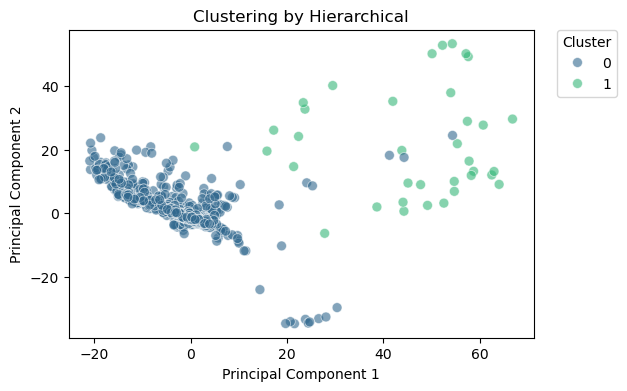

In [27]:
#merged_pca

scaler = StandardScaler()
df_scaled = scaler.fit_transform(merge_2)

pca = PCA(n_components=5)  
components = pca.fit_transform(df_scaled)

pca_df = pd.DataFrame(data=components, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

print("Explained Variance Ratio:", pca.explained_variance_ratio_)

agg_clustering = AgglomerativeClustering()
cluster_labels = agg_clustering.fit_predict(df_scaled)

plt.figure(figsize=(6, 4))
sns.scatterplot(data=pca_df, x=pca_df['PC1'], y=pca_df['PC2'], hue=cluster_labels, palette='viridis', s=50, alpha=0.6)
plt.title('Clustering by Hierarchical')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [134]:
merged_df.to_csv('pdbbind_data.csv')

In [133]:
a = pd.read_csv('pdbbind_data.csv')

a.head()

,Unnamed: 0,PDB,0,1,2,3,4,5,6,7,...,1146,1147,1148,1149,1150,1151,1152,pIC50,Ligand,UniProt AC
0,0,3qc4,-0.000121,0.179341,0.000211,0.165871,0.000260,-0.000577,0.000556,-0.166315,...,0,0,0,0,0,0,0,8.70,MP7,O15530
1,1,4fob,-0.000114,0.159179,0.000207,0.173602,0.000273,-0.000570,0.000511,-0.194982,...,0,0,1,0,0,1,0,8.30,0US,Q9UM73
2,2,4dea,-0.000111,0.154081,0.000213,0.175767,0.000281,-0.000571,0.000497,-0.199414,...,0,0,0,0,0,0,0,6.59,NHI,O14965
3,3,3hvc,-0.000118,0.170417,0.000198,0.170628,0.000263,-0.000570,0.000531,-0.187470,...,1,0,0,0,0,0,0,6.22,GG5,Q16539
4,4,3ti1,-0.000122,0.187234,0.000200,0.165020,0.000249,-0.000568,0.000560,-0.163543,...,0,0,1,0,0,0,0,3.89,B49,P24941
